## Linear least-squares and a bland dense network

We're going to use the MIT-BIH datasets to train and test a basic feedforward network and see how it does. We'll compare the results to a linear regression.

We'll use two different inputs: a mostly unprocessed version of the dataset, and a version in the frequency domain obtained by applying the FFT.

In [1]:
import logging
import numpy as np
import tensorflow as tf

import tools.plotdata as pltdat
import tools.train as train

## Read in data
files = ("../data/mitbih_train.csv", "../data/mitbih_test.csv")
inputs, labels, df = train.preprocess(*files, fft=False)
inputs_fft, labels_fft, _ = train.preprocess(*files, fft=True)
train.class_count(df)


Train set
Count of each class
Classes
0.0    72471
1.0     2223
2.0     5788
3.0      641
4.0     6431
dtype: int64

Test set
Count of each class
Classes
0.0    18118
1.0      556
2.0     1448
3.0      162
4.0     1608
dtype: int64


Let's look at a few random samples of the training data:

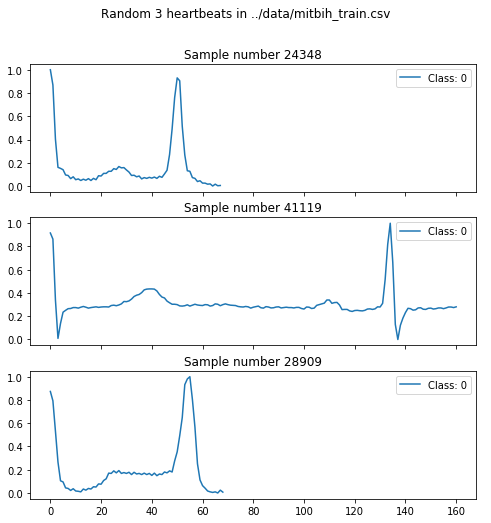

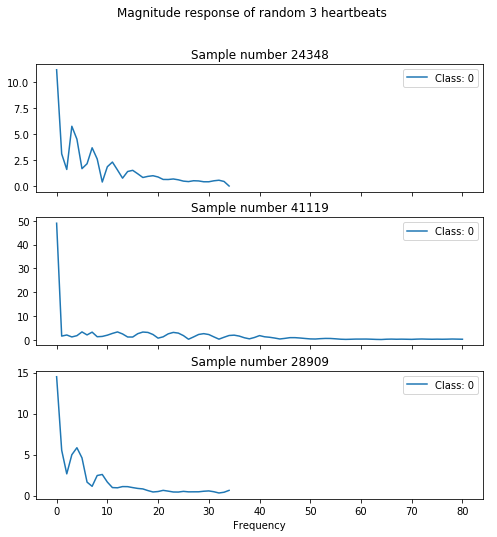

In [2]:
pltdat.plot_ecg(files[0], 3)

### Least-squares
Let's try least-squares regression with numpy.

In [3]:
lstsq_soln = np.linalg.lstsq(inputs["train"], labels["train"], rcond=None)
lstsq_soln_fft = np.linalg.lstsq(inputs_fft["train"], labels_fft["train"], rcond=None)
print("Rank of training dataset:", lstsq_soln[2])
print("Rank of training dataset after (real) FFT:", lstsq_soln_fft[2])

Rank of training dataset: 187
Rank of training dataset after (real) FFT: 94


Now let's see how accurate it is.

In [4]:
def lstsq_accuracy(inputs, labels, coeffs):
    
    predict = {}
    accuracy = {}
    for key in inputs:
        predict[key] = np.argmax(np.dot(inputs[key], coeffs), axis=1)
        num_correct = np.sum(
            labels[key][range(labels[key].shape[0]), predict[key]] == 1
        )
        accuracy[key] = num_correct / labels[key].shape[0]
    print("Training accuracy:", accuracy["train"])
    print("Test accuracy:", accuracy["test"])

print("Regular least-squares")
lstsq_accuracy(inputs, labels, lstsq_soln[0])

Regular least-squares
Training accuracy: 0.8948306188181008
Test accuracy: 0.8952128631463548


In [5]:
print("After FFT")
lstsq_accuracy(inputs_fft, labels_fft, lstsq_soln_fft[0])

After FFT
Training accuracy: 0.9001073623135436
Test accuracy: 0.8965375479627261


### Dense feed-forward network
Let's try an unregularized, bland feed-forward network with a couple of hidden layers.

In [6]:
config = {"batch_size": 200, "val_split": 0.2, "epochs": 50}
hiddenlayers = [(5, "relu"), (5, "relu")]
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

print("Unprocessed data")
train.train_dense(inputs, labels, hiddenlayers, config)

Unprocessed data
Model: "dense_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 187)]             0         
_________________________________________________________________
dense (Dense)                (None, 5)                 940       
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 30        
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 30        
Total params: 1,000
Trainable params: 1,000
Non-trainable params: 0
_________________________________________________________________

Training
Train on 70043 samples, validate on 17511 samples
Epoch 1/50
70043/70043 [==============================] - 2s 29us/sample - loss: 1.0703 - categorical_accuracy: 0.8245 - val_loss: 0.7772 - val_categorical_accuracy: 0.8265
E

In [7]:
print("After FFT")
train.train_dense(inputs_fft, labels_fft, hiddenlayers, config)

After FFT
Model: "dense_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 94)]              0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 475       
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 30        
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 30        
Total params: 535
Trainable params: 535
Non-trainable params: 0
_________________________________________________________________

Training
Train on 70043 samples, validate on 17511 samples
Epoch 1/50
70043/70043 [==============================] - 2s 22us/sample - loss: 0.6109 - categorical_accuracy: 0.8182 - val_loss: 0.4403 - val_categorical_accuracy: 0.8859
Epoch 2/50
7


Testing
21892/21892 [==============================] - 1s 29us/sample - loss: 0.2484 - categorical_accuracy: 0.9319
